### 1.Quantum approach: trivial example

In [3]:
from qiskit import * 
import matplotlib.pyplot as plt
import numpy as np

from qiskit import BasicAer
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import Grover
from qiskit.aqua.components.oracles import LogicalExpressionOracle, TruthTableOracle

### 1.1 Creating oracle  ("oracle" object)
Control-Z gate REPRESENTS (acts as our) Oracle:
    $f(x)=\begin{cases}-11 \text{, x=}11\\ x   \text{       ,else}\end{cases}$
    
In this example state 11 is a "winning state",we defined the oracle this way.

What is the goal?
With minimal calls of f (oracle) ,find the "winning" vector.
    

In [4]:
oracle = QuantumCircuit(2,name='oracle')
oracle.cz(0,1)
oracle.to_gate()
oracle.draw()

q_0: ─■─
      │ 
q_1: ─■─

### 1.2 Testing oracle
Creating "grover_circ" object and appending oracle obj to it

In [5]:
grover_circ=QuantumCircuit(2,2) #2qub, 2 clasical registers
grover_circ.h([0,1]) #adds Had gate to BOTH qub
grover_circ.append(oracle,[0,1])
grover_circ.draw()

┌───┐┌─────────┐
q_0: ┤ H ├┤0        ├
     ├───┤│  oracle │
q_1: ┤ H ├┤1        ├
     └───┘└─────────┘
c: 2/════════════════

### 1.3 (check-step) Initialise the simulator , execute test run and save result 

In [6]:
backend=Aer.get_backend('statevector_simulator')

job=execute(grover_circ,backend)

result = job.result()

### 1.4 (check-step) Display result of the result vector of "grover_circ" circuit
    We prepared the superposition state and got the SAME
    state with 11 flipped.
    
    We NEED to square the state vector
    to get probabilities of measuring that state.

In [7]:
sv= result.get_statevector()
np.round(sv,2)

array([ 0.5+0.j,  0.5+0.j,  0.5+0.j, -0.5+0.j])

## 1.5 Creating Reflection operator   
    We still need the refection operator.
    
    Goal is to amplify probability of the winning state
    AND reduce other probabilities.

    WE APPLY Oracle operator to input state.
    Oracle FLIPPS sign of the state.
    THIS GEOMERTICALY MEANS: we are reflecting original input
    around vector orhogonal to winning state.
    
    NEXT,applying REFL operator on THAT NEW STATE:
    this flipps it ALMOST NEAR |w> ,the winning state.

    For N=4 we just need one iter.of this 2 operators
    for N >> 4 num of iterations will scale as sqrt(N).

In [8]:
reflection= QuantumCircuit(2,name='reflection')

reflection.h([0,1]) #to 00 from s state
reflection.z([0,1])
reflection.cz(0,1)  #will apply neg.phase only to 00
reflection.h([0,1])

reflection.to_gate()
reflection.draw()

┌───┐┌───┐   ┌───┐
q_0: ┤ H ├┤ Z ├─■─┤ H ├
     ├───┤├───┤ │ ├───┤
q_1: ┤ H ├┤ Z ├─■─┤ H ├
     └───┘└───┘   └───┘

### 1.6 Putting it all together

In [9]:
backend= Aer.get_backend('qasm_simulator')

grover_circ=QuantumCircuit(2,2)
grover_circ.h([0,1])

grover_circ.append(oracle,[0,1])
grover_circ.append(reflection,[0,1])

grover_circ.measure([0,1],[0,1])

In [10]:
grover_circ.draw()
#1.our superpos.state
#2.oracle
#3.refl operator
#4.we want at the end state=11

┌───┐┌─────────┐┌─────────────┐┌─┐   
q_0: ┤ H ├┤0        ├┤0            ├┤M├───
     ├───┤│  oracle ││  reflection │└╥┘┌─┐
q_1: ┤ H ├┤1        ├┤1            ├─╫─┤M├
     └───┘└─────────┘└─────────────┘ ║ └╥┘
c: 2/════════════════════════════════╩══╩═
                                     0  1

## 1.7 Result
    Result gave us '11' with '1' call of the oracle.

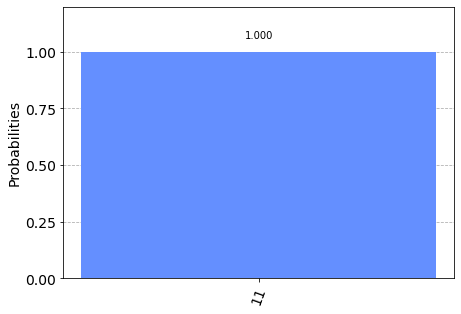

In [14]:
job=execute(grover_circ,backend,shots=1)
result=job.result()
result.get_counts()

plot_histogram(job.result().get_counts())

## 2.0 Example: Logic expression solver (Qiskit implementation)

Small example how Quiskit did a solver, and later I'll try to do simple implementation of it.

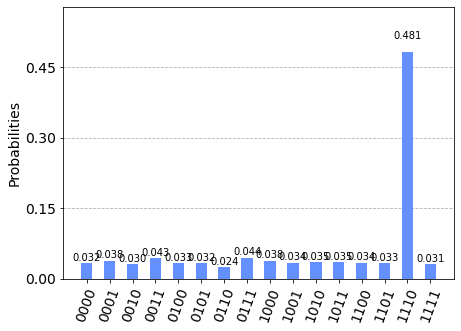

In [4]:
expression = '(w ^ x) & ~(y ^ z) & (x & y & z)'
oracle = LogicalExpressionOracle(expression)
grover = Grover(oracle)
result = grover.run(QuantumInstance(BasicAer.get_backend('qasm_simulator'), shots=1024))
plot_histogram(result.measurement)

## 3.0 Example: Disjunctive normal form solver 


    Input for our program is variable logic.

    It represents a logic expression:

    If for example we want to evaluate  A V B ,
    logic for that would be logic= [[0,0]]       (0 represents there are no negations in front of A ,or B)
    
    For (A V B) && (¬A V ¬B) , logic would be [[0,0],[1,1]]
    
    For A  logic is [0,-1]  (-1 represents that B is absent)
    
    
    I didn't implement this automatization fully, but wanted logic can be inserted to this oracle without using said function and variable logic.
    
    

In [343]:
#logic for a given logical expression
logic= [[-1,0]]      #A OR  B


In [344]:
# Function adds to CIRC a representation of OR between 2 qubits, 
#x and y ,and writes X V Y to qubit r , neg variable 
#represents negation of x or y

def addOR(circ,x,y,r,neg=(0,0)):
    if neg[0] == 1:
        circ.x(x)
    if neg[1]== 1:
        circ.x(y)
        
    circ.x([x,y])
    circ.ccx(x,y,r)
    circ.x([x,y,r])
    
    if neg[0] == 1:
        circ.x(x)
    if neg[1]== 1:
        circ.x(y)
        
    return circ

In [345]:
#NUM OF QUBITS IS DEDUCTED  FROM THE SIZE OF THE LOG.EX.
numOfQubits=3
if len(logic)>1:
    numOfQubits=len(logic)+3


def oracleCreator(logic,numOfQubits): 
    
    
        
        
    o=QuantumCircuit(numOfQubits, name="oracle")    
        
    #ADDING UP ALL DISJUNCTIVE ELEMENTS OF logic variable
    outputQ=2
    for l in logic:
        if l[0]==-1:            #Checks if first variable is absent
            if l[1]==1:
                o.x(1)
            o.cx(1,outputQ)   
            outputQ +=1
            continue
        if l[1]==-1:           #Checks if second variable is absent
            if l[0]==1:        
                o.x(0)
            o.cx(0,outputQ)    
            outputQ +=1
            continue

        o=addOR(o,0,1,outputQ,l)   # A V B   
        outputQ +=1



    #ADS UP EVERY OUTPUT FROM DISJUNCTIVE ELEMENTS 
    if numOfQubits == 5:   
        o.ccx(2,3,4)            
        o.z(4)
    else:
        o.z(2)



    #REVERSING THE GATE AFTER TRIGGERING Z GATE
    ###########################################
    
    if numOfQubits == 5:   
        o.ccx(2,3,4)    

    outputQ=2
    for l in reversed(logic):
        if l[0]==-1:            #Checks if first variable is absent
            if l[1]==1:
                o.x(1)
            o.cx(1,outputQ)   
            outputQ +=1
            continue
        if l[1]==-1:           #Checks if second variable is absent
            if l[0]==1:        
                o.x(0)
            o.cx(0,outputQ)    
            outputQ +=1
            continue

        o=addOR(o,0,1,outputQ,l)   # A V B   
        outputQ +=1


    o.to_gate()
    return o


o=oracleCreator(logic,numOfQubits)



In [346]:
o.draw()

q_0: ───────────────
                    
q_1: ──■─────────■──
     ┌─┴─┐┌───┐┌─┴─┐
q_2: ┤ X ├┤ Z ├┤ X ├
     └───┘└───┘└───┘

### 3.1 Diffuser: Qiskit implementation for n qubits

In [347]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

### 3.3 Finishing the code

Addeed H gate to the input , then just oracle and reflection circuit need to be appended.

In [355]:

if numOfQubits==3:
    out=[0,1,2]
if numOfQubits==5:
    out=[0,1,2,3,4] 

grover_circ=QuantumCircuit(numOfQubits,2)
grover_circ.h([0,1])

grover_circ.append(o,out)
grover_circ.append(diffuser(2),[0,1])

#grover_circ.append(o,out)
#grover_circ.append(diffuser(2),[0,1])

grover_circ.measure([0,1],[0,1])
    


### 3.4 Simulating the code

In [356]:
backend= Aer.get_backend('qasm_simulator')

job=execute(grover_circ,backend)
result=job.result()
result.get_counts()


{'00': 261, '01': 270, '10': 246, '11': 247}

### 3.5 Showing output on histogram

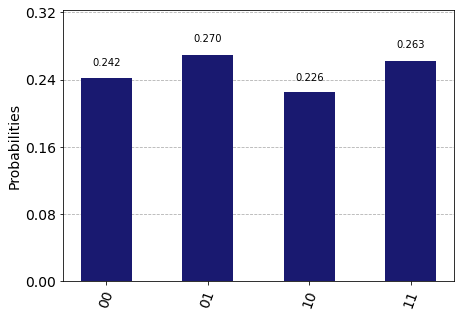

In [357]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(grover_circ, backend)
plot_histogram(job.result().get_counts(), color='midnightblue')

In [358]:
grover_circ.draw()

┌───┐┌─────────┐┌────────┐┌─┐   
q_0: ┤ H ├┤0        ├┤0       ├┤M├───
     ├───┤│         ││  U$_s$ │└╥┘┌─┐
q_1: ┤ H ├┤1 oracle ├┤1       ├─╫─┤M├
     └───┘│         │└────────┘ ║ └╥┘
q_2: ─────┤2        ├───────────╫──╫─
          └─────────┘           ║  ║ 
c: 2/═══════════════════════════╩══╩═
                                0  1